In [1]:
%matplotlib inline
import netCDF4
import rasterio
import os
from datetime import datetime
import numpy as np
import spotpy
import matplotlib.pyplot as plt

In [2]:
# local libraries
from coupling_PCR_FM.model_functions_v2 import PCR_model, CMF_model, DFM_model
from coupling_PCR_FM.utils import config_to_dict, determineSteps
%config Application.log_level="INFO"

In [3]:
# IMPORT MODEL SETTINGS FROM INI-FILE
argv1 = r'default_rename.set'
argv2 = r'paths.env'

# parse set/ini-file with central/general settings for coupling framework
config = config_to_dict(argv1)
# parse env-file for user-specific paths and environmental variables
envs = config_to_dict(argv2)
# combine
config.update(envs)
options = config
# parse dates
start_date = datetime.strptime(options['numerical_settings']['startTime'], '%Y-%m-%d')
end_date = datetime.strptime(options['numerical_settings']['endTime'], '%Y-%m-%d')
print start_date
print end_date
timeSteps = determineSteps(start_date, end_date)
print timeSteps

2000-01-01 00:00:00
2001-12-31 00:00:00
730


In [4]:
# setup output dir
cwd = os.getcwd() # note: this get changed by pcr initialization later on
out_dir = options['PCRpaths']['outputDirectoryPCR']
out_dir = out_dir + 'PCR2CMF/'
if not os.path.isdir(out_dir):
    os.mkdir(out_dir)
print(out_dir)
print(cwd)

/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/
/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


## create PCR model BMI object

Note that we use a two step initializiation. in the first step the bmi object is initialized and the model config file is read into memory. This config file can then be changed offline before the model is initialized. This allows for change model input files and setting based on the model coupling.

In [5]:
PCR_configfile = os.path.join(cwd, options['hydrologic_model']['config_dir'], options['hydrologic_model']['config_file'])
PCR_in_dir = options['PCRpaths']['inputDirectoryPCR']
PCR_out_dir = os.path.join(out_dir, 'PCR')

PCR_bmi = PCR_model(PCR_configfile, PCR_in_dir, PCR_out_dir,
                            start_date, end_date)


The illustrate the two-step initialization, the model config file is shown

In [6]:
PCR_bmi.model_config

OrderedDict([(u'globalOptions',
              OrderedDict([('inputDir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/PCR_Elbe/input30min'),
                           ('cloneMap', u'clone_elbe_30min.map'),
                           ('landmask', u'landmask_elbe_30min.map'),
                           ('outputDir',
                            u'/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR'),
                           ('institution',
                            u'Department of Physical Geography, Utrecht University'),
                           ('title', u'PCR-GLOBWB output'),
                           ('description',
                            u'test version by Edwin H. Sutanudjaja; adapted by J. Hoch'),
                           ('startTime', '2000-01-01'),
                           ('endTime', '2001-12-31'),
                           ('maxSpinUpsInYears', u'1'),
                           ('minConvForTotlSto', u'0.5'),
  

## create CMF model BMi object

In [7]:
CMF_engine = os.path.join(cwd, options['CMF_engine']['CMF_path'])
CMF_model_dir = os.path.join(cwd, options['routing_model']['model_dir'])
CMF_config_fn = os.path.join(CMF_model_dir, options['routing_model']['model_file'])
CMF_out_dir = os.path.join(out_dir, 'CMF')
     
CMF_bmi = CMF_model(CMF_engine, CMF_config_fn, CMF_model_dir, CMF_out_dir,
                         start_date, end_date)

## couple grids based on CMF inpmat file

In [8]:
# couple
PCR_bmi.couple_grid_to_grid(CMF_bmi)

## initialize models

In [9]:
# initialize model at CMF_out_dir after inpmat has been set in the grid_to_grid coupling function.
CMF_bmi.initialize()
# initialize model 
PCR_bmi.initialize()

INFO: configuration.initialize_logging(): Model run started at 2018-03-16 12:16:47.343682
2018-03-16 12:16:47,349 pcrglobwb_bmi_v203.configuration INFO Model run started at 2018-03-16 12:16:47.343682
INFO: configuration.initialize_logging(): Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-16T12:16:47.343682.log
2018-03-16 12:16:47,351 pcrglobwb_bmi_v203.configuration INFO Logging output to /home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/PCR/log/setup_PCR_30min_Elbe.ini_2018-03-16T12:16:47.343682.log
INFO: configuration.repair_ini_key_names(): Note that avgSurfaceWaterInputLongIni is not used and not needed.
2018-03-16 12:16:47,352 pcrglobwb_bmi_v203.configuration INFO Note that avgSurfaceWaterInputLongIni is not used and not needed.
INFO: configuration.repair_ini_key_names(): The initial condition "subDischargeIni" is not defined. Either "avgDischargeShortIni" or "avgDischargeLongIni" is used in this run. No

## run coupled PCR - CMF model

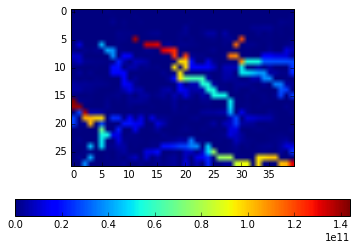

In [10]:
#- get upsteram area at comparison point in CMF
upArea = np.fromfile(r'/home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim/test_Elbe/CMF_Elbe/uparea.bin', 'f').reshape(28,40)
plt.imshow(upArea)
plt.colorbar(orientation='horizontal')

In [11]:
#- check whether upstream area at chosen location is at the upper end
#- upstream area according to GRDC: 131950 km2 = 1.31950e11 m2
xCMFout = 6
yCMFout = 13
print (upArea[xCMFout, yCMFout])

1.34112e+11


In [12]:
# create file for writing CMF output
cmf_outFile = os.path.join(CMF_out_dir, 'qsim_CFM_at_location_' + str(xCMFout) + '_' + str(yCMFout) + '.txt')
cmf_of = open(cmf_outFile, 'w')
print (cmf_of)

<open file u'/home/jannis/PhD/code/GLOFRIMplusCAMA/output30min/PCR2CMF/CMF/qsim_CFM_at_location_6_13.txt', mode 'w' at 0x7f09e772e540>


In [13]:
# run coupled model for 20 timesteps
def update_states():
    "coupling runoff between CMFan PCR model"
    runoff = PCR_bmi.get_var('landSurfaceRunoff')
    runoff = np.where(np.isnan(runoff), 0, runoff)
    CMF_bmi.set_var("roffin", runoff)
        
tStart = datetime.now()
for i in range(timeSteps):
# for i in range(20):
    PCR_bmi.update()
    update_states()
    CMF_bmi.update()  
    outflw_temp = np.copy(CMF_bmi.get_var('outflw'))[xCMFout, yCMFout]
    cmf_of.write(str(outflw_temp) + os.linesep)
tEnd = datetime.now()
cmf_of.close()

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-01
2018-03-16 12:17:01,282 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-01
INFO: pcrglobwb.update(): updating model to time 2000-01-01
2018-03-16 12:17:01,573 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
2018-03-16 12:17:03,748 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-01, timestep 1
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
2018-03-16 12:17:03,981 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-02 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-02
2018-03-16 12:17:03,983 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-02
INFO

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-11
2018-03-16 12:17:18,559 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-11
INFO: pcrglobwb.update(): updating model to time 2000-01-11
2018-03-16 12:17:18,913 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
2018-03-16 12:17:20,040 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-11, timestep 11
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
2018-03-16 12:17:20,090 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-12
2018-03-16 12:17:20,096 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-12
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-21
2018-03-16 12:17:34,534 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-21
INFO: pcrglobwb.update(): updating model to time 2000-01-21
2018-03-16 12:17:34,941 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
2018-03-16 12:17:36,164 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-21, timestep 21
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-22 00:00:00, timestep 86400.0
2018-03-16 12:17:36,227 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-01-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-22
2018-03-16 12:17:36,230 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-22
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-01-31
2018-03-16 12:17:51,399 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-01-31
INFO: pcrglobwb.update(): updating model to time 2000-01-31
2018-03-16 12:17:51,720 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-01-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
2018-03-16 12:17:52,829 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-01-31, timestep 31
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-01 00:00:00, timestep 86400.0
2018-03-16 12:17:52,902 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-01
2018-03-16 12:17:52,908 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-01
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-10
2018-03-16 12:18:07,905 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-10
INFO: pcrglobwb.update(): updating model to time 2000-02-10
2018-03-16 12:18:08,246 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
2018-03-16 12:18:09,385 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-10, timestep 41
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-11 00:00:00, timestep 86400.0
2018-03-16 12:18:09,419 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-11
2018-03-16 12:18:09,424 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-11
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-20
2018-03-16 12:18:24,569 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-20
INFO: pcrglobwb.update(): updating model to time 2000-02-20
2018-03-16 12:18:24,953 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-02-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
2018-03-16 12:18:26,105 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-02-20, timestep 51
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-21 00:00:00, timestep 86400.0
2018-03-16 12:18:26,144 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-02-21 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-02-21
2018-03-16 12:18:26,146 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-02-21
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-01
2018-03-16 12:18:40,950 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-01
INFO: pcrglobwb.update(): updating model to time 2000-03-01
2018-03-16 12:18:41,445 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61
2018-03-16 12:18:42,882 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-01, timestep 61
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-02 00:00:00, timestep 86400.0
2018-03-16 12:18:43,156 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-02 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-02
2018-03-16 12:18:43,159 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-02
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-11
2018-03-16 12:18:58,021 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-11
INFO: pcrglobwb.update(): updating model to time 2000-03-11
2018-03-16 12:18:58,462 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
2018-03-16 12:18:59,592 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-11, timestep 71
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
2018-03-16 12:18:59,687 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-12
2018-03-16 12:18:59,693 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-12
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-21
2018-03-16 12:19:14,547 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-21
INFO: pcrglobwb.update(): updating model to time 2000-03-21
2018-03-16 12:19:14,986 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81
2018-03-16 12:19:16,121 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-21, timestep 81
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-22 00:00:00, timestep 86400.0
2018-03-16 12:19:16,186 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-03-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-22
2018-03-16 12:19:16,192 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-22
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-03-31
2018-03-16 12:19:31,016 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-03-31
INFO: pcrglobwb.update(): updating model to time 2000-03-31
2018-03-16 12:19:31,460 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-03-31
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91
2018-03-16 12:19:32,597 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-03-31, timestep 91
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-01 00:00:00, timestep 86400.0
2018-03-16 12:19:32,646 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-01
2018-03-16 12:19:32,651 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-01
IN

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-10
2018-03-16 12:19:47,734 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-10
INFO: pcrglobwb.update(): updating model to time 2000-04-10
2018-03-16 12:19:48,081 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101
2018-03-16 12:19:49,204 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-10, timestep 101
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-11 00:00:00, timestep 86400.0
2018-03-16 12:19:49,248 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-11
2018-03-16 12:19:49,255 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-11


2018-03-16 12:20:04,040 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-20 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-20
2018-03-16 12:20:04,048 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-20
INFO: pcrglobwb.update(): updating model to time 2000-04-20
2018-03-16 12:20:04,490 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111
2018-03-16 12:20:05,633 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-20, timestep 111
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-21 00:00:00, timestep 86400.0
2018-03-16 12:20:05,689 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-21 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-30 00:00:00, timestep 86400.0
2018-03-16 12:20:20,444 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-04-30 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-04-30
2018-03-16 12:20:20,447 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-04-30
INFO: pcrglobwb.update(): updating model to time 2000-04-30
2018-03-16 12:20:20,883 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-04-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121
2018-03-16 12:20:22,045 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-04-30, timestep 121
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-01 00:00:00, timestep 86400.0
2018-03-16 12:20:22,074 coupling_PCR_FM

2018-03-16 12:20:37,121 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-09, timestep 130
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-10 00:00:00, timestep 86400.0
2018-03-16 12:20:37,173 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-10 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-10
2018-03-16 12:20:37,180 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-10
INFO: pcrglobwb.update(): updating model to time 2000-05-10
2018-03-16 12:20:37,596 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131
2018-03-16 12:20:38,800 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-10, timestep 131
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140
2018-03-16 12:20:53,593 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-19, timestep 140
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
2018-03-16 12:20:53,635 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-20 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-20
2018-03-16 12:20:53,637 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-20
INFO: pcrglobwb.update(): updating model to time 2000-05-20
2018-03-16 12:20:54,039 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-20, timestep 141
2018-03-16 12:20:55,214 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-05-29
2018-03-16 12:21:09,033 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150
2018-03-16 12:21:10,187 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-05-29, timestep 150
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-30 00:00:00, timestep 86400.0
2018-03-16 12:21:10,252 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-05-30 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-05-30
2018-03-16 12:21:10,255 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-05-30
INFO: pcrglobwb.update(): updating model to time 2000-05-30
2018-03-16 12:21:10,664 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-05-30
INFO: model_f

2018-03-16 12:21:24,878 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-08
INFO: pcrglobwb.update(): updating model to time 2000-06-08
2018-03-16 12:21:25,307 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160
2018-03-16 12:21:26,469 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-08, timestep 160
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-09 00:00:00, timestep 86400.0
2018-03-16 12:21:26,581 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-09 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-09
2018-03-16 12:21:26,589 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-09
INFO: pcrglobwb.update(): updating model to time 2000-06-09
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-18
2018-03-16 12:21:41,118 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-18
INFO: pcrglobwb.update(): updating model to time 2000-06-18
2018-03-16 12:21:41,542 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170
2018-03-16 12:21:42,711 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-18, timestep 170
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-19 00:00:00, timestep 86400.0
2018-03-16 12:21:42,769 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-19
2018-03-16 12:21:42,772 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-19


2018-03-16 12:21:57,588 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-28 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-06-28
2018-03-16 12:21:57,591 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-06-28
INFO: pcrglobwb.update(): updating model to time 2000-06-28
2018-03-16 12:21:57,937 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-06-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
2018-03-16 12:21:59,031 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-06-28, timestep 180
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-29 00:00:00, timestep 86400.0
2018-03-16 12:21:59,046 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-06-29 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-08 00:00:00, timestep 86400.0
2018-03-16 12:22:14,214 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-08 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-08
2018-03-16 12:22:14,216 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-08
INFO: pcrglobwb.update(): updating model to time 2000-07-08
2018-03-16 12:22:14,507 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-08
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
2018-03-16 12:22:15,705 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-08, timestep 190
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-09 00:00:00, timestep 86400.0
2018-03-16 12:22:15,763 coupling_PCR_FM

2018-03-16 12:22:30,514 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-17, timestep 199
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-18 00:00:00, timestep 86400.0
2018-03-16 12:22:30,585 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-18 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-18
2018-03-16 12:22:30,591 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-18
INFO: pcrglobwb.update(): updating model to time 2000-07-18
2018-03-16 12:22:31,004 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-18
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200
2018-03-16 12:22:32,139 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-18, timestep 200
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209
2018-03-16 12:22:47,232 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-07-27, timestep 209
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-28 00:00:00, timestep 86400.0
2018-03-16 12:22:47,317 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-07-28 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-07-28
2018-03-16 12:22:47,320 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-07-28
INFO: pcrglobwb.update(): updating model to time 2000-07-28
2018-03-16 12:22:47,784 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-07-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-07-28, timestep 210
2018-03-16 12:22:48,930 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-08-06
2018-03-16 12:23:03,068 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-06
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219
2018-03-16 12:23:04,243 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-06, timestep 219
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-07 00:00:00, timestep 86400.0
2018-03-16 12:23:04,308 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-07 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-07
2018-03-16 12:23:04,311 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-07
INFO: pcrglobwb.update(): updating model to time 2000-08-07
2018-03-16 12:23:04,650 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-07
INFO: model_f

2018-03-16 12:23:19,091 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-16
INFO: pcrglobwb.update(): updating model to time 2000-08-16
2018-03-16 12:23:19,570 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-16
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229
2018-03-16 12:23:20,743 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-16, timestep 229
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-17 00:00:00, timestep 86400.0
2018-03-16 12:23:20,800 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-17 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-17
2018-03-16 12:23:20,806 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-17
INFO: pcrglobwb.update(): updating model to time 2000-08-17
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-26
2018-03-16 12:23:35,738 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-26
INFO: pcrglobwb.update(): updating model to time 2000-08-26
2018-03-16 12:23:36,118 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-08-26
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239
2018-03-16 12:23:37,296 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-08-26, timestep 239
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-27 00:00:00, timestep 86400.0
2018-03-16 12:23:37,351 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-08-27 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-08-27
2018-03-16 12:23:37,357 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-08-27


2018-03-16 12:23:52,994 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-05 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-05
2018-03-16 12:23:52,996 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-05
INFO: pcrglobwb.update(): updating model to time 2000-09-05
2018-03-16 12:23:53,372 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
2018-03-16 12:23:54,566 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-05, timestep 249
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
2018-03-16 12:23:54,632 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-06 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-15 00:00:00, timestep 86400.0
2018-03-16 12:24:09,388 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-15 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-15
2018-03-16 12:24:09,390 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-15
INFO: pcrglobwb.update(): updating model to time 2000-09-15
2018-03-16 12:24:09,762 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259
2018-03-16 12:24:10,900 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-15, timestep 259
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-16 00:00:00, timestep 86400.0
2018-03-16 12:24:10,948 coupling_PCR_FM

2018-03-16 12:24:25,737 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-24, timestep 268
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-25 00:00:00, timestep 86400.0
2018-03-16 12:24:25,828 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-09-25 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-09-25
2018-03-16 12:24:25,837 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-09-25
INFO: pcrglobwb.update(): updating model to time 2000-09-25
2018-03-16 12:24:26,204 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-09-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269
2018-03-16 12:24:27,372 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-09-25, timestep 269
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278
2018-03-16 12:24:42,771 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-04, timestep 278
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-05 00:00:00, timestep 86400.0
2018-03-16 12:24:42,922 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-05 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-05
2018-03-16 12:24:42,926 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-05
INFO: pcrglobwb.update(): updating model to time 2000-10-05
2018-03-16 12:24:43,383 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-05, timestep 279
2018-03-16 12:24:44,503 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-10-14
2018-03-16 12:24:58,174 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
2018-03-16 12:24:59,347 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-14, timestep 288
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
2018-03-16 12:24:59,421 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-15 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-15
2018-03-16 12:24:59,424 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-15
INFO: pcrglobwb.update(): updating model to time 2000-10-15
2018-03-16 12:24:59,863 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-15
INFO: model_f

2018-03-16 12:25:14,328 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-24
INFO: pcrglobwb.update(): updating model to time 2000-10-24
2018-03-16 12:25:14,691 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-10-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298
2018-03-16 12:25:15,810 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-10-24, timestep 298
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-25 00:00:00, timestep 86400.0
2018-03-16 12:25:15,859 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-10-25 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-10-25
2018-03-16 12:25:15,861 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-10-25
INFO: pcrglobwb.update(): updating model to time 2000-10-25
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-03
2018-03-16 12:25:31,079 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-03
INFO: pcrglobwb.update(): updating model to time 2000-11-03
2018-03-16 12:25:31,506 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308
2018-03-16 12:25:32,654 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-03, timestep 308
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-04 00:00:00, timestep 86400.0
2018-03-16 12:25:32,719 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-04 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-04
2018-03-16 12:25:32,725 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-04


2018-03-16 12:25:47,341 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-13 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-13
2018-03-16 12:25:47,347 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-13
INFO: pcrglobwb.update(): updating model to time 2000-11-13
2018-03-16 12:25:47,728 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318
2018-03-16 12:25:48,944 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-13, timestep 318
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-14 00:00:00, timestep 86400.0
2018-03-16 12:25:49,013 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-14 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-23 00:00:00, timestep 86400.0
2018-03-16 12:26:03,932 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-23 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-11-23
2018-03-16 12:26:03,934 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-11-23
INFO: pcrglobwb.update(): updating model to time 2000-11-23
2018-03-16 12:26:04,314 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-11-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328
2018-03-16 12:26:05,482 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-11-23, timestep 328
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-11-24 00:00:00, timestep 86400.0
2018-03-16 12:26:05,519 coupling_PCR_FM

2018-03-16 12:26:20,935 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-02, timestep 337
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-03 00:00:00, timestep 86400.0
2018-03-16 12:26:20,957 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-03 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-03
2018-03-16 12:26:20,960 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-03
INFO: pcrglobwb.update(): updating model to time 2000-12-03
2018-03-16 12:26:21,313 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-03
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338
2018-03-16 12:26:22,410 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-03, timestep 338
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347
2018-03-16 12:26:37,641 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-12, timestep 347
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-13 00:00:00, timestep 86400.0
2018-03-16 12:26:37,658 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-13 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-13
2018-03-16 12:26:37,663 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-13
INFO: pcrglobwb.update(): updating model to time 2000-12-13
2018-03-16 12:26:38,016 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-13, timestep 348
2018-03-16 12:26:39,203 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2000-12-22
2018-03-16 12:26:52,454 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357
2018-03-16 12:26:53,585 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-22, timestep 357
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
2018-03-16 12:26:53,634 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2000-12-23 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2000-12-23
2018-03-16 12:26:53,637 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2000-12-23
INFO: pcrglobwb.update(): updating model to time 2000-12-23
2018-03-16 12:26:53,990 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2000-12-23
INFO: model_f

INFO: pcrglobwb.report(): Accumulated precipitation days 1 to 366 in 2000 = 9.355974e+01 km3 = 6.273453e+02 mm
2018-03-16 12:27:08,277 model INFO Accumulated precipitation days 1 to 366 in 2000 = 9.355974e+01 km3 = 6.273453e+02 mm
INFO: pcrglobwb.report(): Accumulated nonFossilGroundwaterAbs days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
2018-03-16 12:27:08,278 model INFO Accumulated nonFossilGroundwaterAbs days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
INFO: pcrglobwb.report(): Accumulated allocNonFossilGroundwater days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
2018-03-16 12:27:08,280 model INFO Accumulated allocNonFossilGroundwater days 1 to 366 in 2000 = 9.021893e+00 km3 = 6.049442e+01 mm
INFO: pcrglobwb.report(): Accumulated baseflow days 1 to 366 in 2000 = 1.965035e+01 km3 = 1.317613e+02 mm
2018-03-16 12:27:08,281 model INFO Accumulated baseflow days 1 to 366 in 2000 = 1.965035e+01 km3 = 1.317613e+02 mm
INFO: pcrglobwb.report(): Accumulated surf

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2000-12-31, timestep 366
2018-03-16 12:27:08,321 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2000-12-31, timestep 366
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-01 00:00:00, timestep 86400.0
2018-03-16 12:27:08,443 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-01
2018-03-16 12:27:08,445 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-01
INFO: pcrglobwb.update(): updating model to time 2001-01-01
2018-03-16 12:27:08,836 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-01, timestep 367
2018-03-16 12:27:11,103 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-01-10
2018-03-16 12:27:25,041 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-10
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-10, timestep 376
2018-03-16 12:27:26,227 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-10, timestep 376
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-11 00:00:00, timestep 86400.0
2018-03-16 12:27:26,273 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-11
2018-03-16 12:27:26,276 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-11
INFO: pcrglobwb.update(): updating model to time 2001-01-11
2018-03-16 12:27:26,703 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-11
INFO: model_f

2018-03-16 12:27:41,552 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-20
INFO: pcrglobwb.update(): updating model to time 2001-01-20
2018-03-16 12:27:42,027 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-20, timestep 386
2018-03-16 12:27:43,105 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-20, timestep 386
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-21 00:00:00, timestep 86400.0
2018-03-16 12:27:43,148 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-21 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-21
2018-03-16 12:27:43,151 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-21
INFO: pcrglobwb.update(): updating model to time 2001-01-21
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-30
2018-03-16 12:27:58,713 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-30
INFO: pcrglobwb.update(): updating model to time 2001-01-30
2018-03-16 12:27:59,127 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-01-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
2018-03-16 12:28:00,274 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-01-30, timestep 396
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-31 00:00:00, timestep 86400.0
2018-03-16 12:28:00,412 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-01-31 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-01-31
2018-03-16 12:28:00,417 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-01-31


2018-03-16 12:28:15,673 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-09 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-09
2018-03-16 12:28:15,678 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-09
INFO: pcrglobwb.update(): updating model to time 2001-02-09
2018-03-16 12:28:16,055 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-09, timestep 406
2018-03-16 12:28:17,256 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-09, timestep 406
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-10 00:00:00, timestep 86400.0
2018-03-16 12:28:17,343 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-10 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-19 00:00:00, timestep 86400.0
2018-03-16 12:28:32,219 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-02-19
2018-03-16 12:28:32,222 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-02-19
INFO: pcrglobwb.update(): updating model to time 2001-02-19
2018-03-16 12:28:32,654 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-02-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-02-19, timestep 416
2018-03-16 12:28:33,828 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-19, timestep 416
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-02-20 00:00:00, timestep 86400.0
2018-03-16 12:28:33,852 coupling_PCR_FM

2018-03-16 12:28:48,694 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-02-28, timestep 425
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-01 00:00:00, timestep 86400.0
2018-03-16 12:28:48,738 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-01 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-01
2018-03-16 12:28:48,741 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-01
INFO: pcrglobwb.update(): updating model to time 2001-03-01
2018-03-16 12:28:49,179 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-01
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-01, timestep 426
2018-03-16 12:28:50,692 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-01, timestep 426
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-10, timestep 435
2018-03-16 12:29:05,841 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-10, timestep 435
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-11 00:00:00, timestep 86400.0
2018-03-16 12:29:05,923 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-11 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-11
2018-03-16 12:29:05,926 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-11
INFO: pcrglobwb.update(): updating model to time 2001-03-11
2018-03-16 12:29:06,314 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-11
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-11, timestep 436
2018-03-16 12:29:07,507 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-03-20
2018-03-16 12:29:21,012 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-20
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-20, timestep 445
2018-03-16 12:29:22,206 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-20, timestep 445
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-21 00:00:00, timestep 86400.0
2018-03-16 12:29:22,306 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-21 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-21
2018-03-16 12:29:22,310 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-21
INFO: pcrglobwb.update(): updating model to time 2001-03-21
2018-03-16 12:29:22,722 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-21
INFO: model_f

2018-03-16 12:29:37,318 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-30
INFO: pcrglobwb.update(): updating model to time 2001-03-30
2018-03-16 12:29:37,700 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-03-30
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-03-30, timestep 455
2018-03-16 12:29:38,916 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-03-30, timestep 455
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-31 00:00:00, timestep 86400.0
2018-03-16 12:29:38,989 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-03-31 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-03-31
2018-03-16 12:29:38,995 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-03-31
INFO: pcrglobwb.update(): updating model to time 2001-03-31
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-09
2018-03-16 12:29:54,385 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-09
INFO: pcrglobwb.update(): updating model to time 2001-04-09
2018-03-16 12:29:54,831 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
2018-03-16 12:29:56,013 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-09, timestep 465
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
2018-03-16 12:29:56,093 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-10 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-10
2018-03-16 12:29:56,095 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-10


2018-03-16 12:30:11,145 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-19
2018-03-16 12:30:11,151 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-19
INFO: pcrglobwb.update(): updating model to time 2001-04-19
2018-03-16 12:30:11,568 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-19, timestep 475
2018-03-16 12:30:12,597 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-19, timestep 475
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-20 00:00:00, timestep 86400.0
2018-03-16 12:30:12,622 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-20 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-29 00:00:00, timestep 86400.0
2018-03-16 12:30:27,477 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-29 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-04-29
2018-03-16 12:30:27,483 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-04-29
INFO: pcrglobwb.update(): updating model to time 2001-04-29
2018-03-16 12:30:27,859 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-04-29
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-04-29, timestep 485
2018-03-16 12:30:29,021 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-04-29, timestep 485
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-04-30 00:00:00, timestep 86400.0
2018-03-16 12:30:29,083 coupling_PCR_FM

2018-03-16 12:30:44,449 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-08, timestep 494
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-09 00:00:00, timestep 86400.0
2018-03-16 12:30:44,568 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-09 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-09
2018-03-16 12:30:44,574 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-09
INFO: pcrglobwb.update(): updating model to time 2001-05-09
2018-03-16 12:30:44,998 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-09
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-09, timestep 495
2018-03-16 12:30:46,235 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-09, timestep 495
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
2018-03-16 12:31:01,232 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-18, timestep 504
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
2018-03-16 12:31:01,433 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-19 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-19
2018-03-16 12:31:01,440 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-19
INFO: pcrglobwb.update(): updating model to time 2001-05-19
2018-03-16 12:31:01,877 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-19
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-19, timestep 505
2018-03-16 12:31:03,088 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-05-28
2018-03-16 12:31:16,852 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-28
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-05-28, timestep 514
2018-03-16 12:31:18,014 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-05-28, timestep 514
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-29 00:00:00, timestep 86400.0
2018-03-16 12:31:18,104 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-05-29 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-05-29
2018-03-16 12:31:18,114 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-05-29
INFO: pcrglobwb.update(): updating model to time 2001-05-29
2018-03-16 12:31:18,572 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-05-29
INFO: model_f

2018-03-16 12:31:33,230 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-07
INFO: pcrglobwb.update(): updating model to time 2001-06-07
2018-03-16 12:31:33,511 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-07, timestep 524
2018-03-16 12:31:34,698 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-07, timestep 524
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-08 00:00:00, timestep 86400.0
2018-03-16 12:31:34,736 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-08 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-08
2018-03-16 12:31:34,741 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-08
INFO: pcrglobwb.update(): updating model to time 2001-06-08
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-17
2018-03-16 12:31:49,965 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-17
INFO: pcrglobwb.update(): updating model to time 2001-06-17
2018-03-16 12:31:50,371 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-17, timestep 534
2018-03-16 12:31:51,603 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-17, timestep 534
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-18 00:00:00, timestep 86400.0
2018-03-16 12:31:51,645 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-18 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-18
2018-03-16 12:31:51,652 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-18


2018-03-16 12:32:06,593 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-27 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-06-27
2018-03-16 12:32:06,595 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-06-27
INFO: pcrglobwb.update(): updating model to time 2001-06-27
2018-03-16 12:32:07,012 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-06-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-06-27, timestep 544
2018-03-16 12:32:08,085 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-06-27, timestep 544
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-28 00:00:00, timestep 86400.0
2018-03-16 12:32:08,136 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-06-28 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-07 00:00:00, timestep 86400.0
2018-03-16 12:32:23,331 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-07 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-07
2018-03-16 12:32:23,334 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-07
INFO: pcrglobwb.update(): updating model to time 2001-07-07
2018-03-16 12:32:23,869 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-07
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-07, timestep 554
2018-03-16 12:32:24,979 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-07, timestep 554
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-08 00:00:00, timestep 86400.0
2018-03-16 12:32:25,139 coupling_PCR_FM

2018-03-16 12:32:40,407 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-16, timestep 563
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-17 00:00:00, timestep 86400.0
2018-03-16 12:32:40,568 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-17 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-17
2018-03-16 12:32:40,573 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-17
INFO: pcrglobwb.update(): updating model to time 2001-07-17
2018-03-16 12:32:41,046 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-17
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-17, timestep 564
2018-03-16 12:32:42,224 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-17, timestep 564
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-26, timestep 573
2018-03-16 12:32:57,292 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-07-26, timestep 573
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-27 00:00:00, timestep 86400.0
2018-03-16 12:32:57,399 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-07-27 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-07-27
2018-03-16 12:32:57,408 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-07-27
INFO: pcrglobwb.update(): updating model to time 2001-07-27
2018-03-16 12:32:57,818 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-07-27
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-07-27, timestep 574
2018-03-16 12:32:58,994 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-08-05
2018-03-16 12:33:13,123 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-05
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-05, timestep 583
2018-03-16 12:33:14,266 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-05, timestep 583
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-06 00:00:00, timestep 86400.0
2018-03-16 12:33:14,316 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-06 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-06
2018-03-16 12:33:14,319 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-06
INFO: pcrglobwb.update(): updating model to time 2001-08-06
2018-03-16 12:33:14,719 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-06
INFO: model_f

2018-03-16 12:33:29,182 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-15
INFO: pcrglobwb.update(): updating model to time 2001-08-15
2018-03-16 12:33:29,569 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-15
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-15, timestep 593
2018-03-16 12:33:30,737 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-15, timestep 593
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-16 00:00:00, timestep 86400.0
2018-03-16 12:33:30,805 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-16 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-16
2018-03-16 12:33:30,812 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-16
INFO: pcrglobwb.update(): updating model to time 2001-08-16
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-25
2018-03-16 12:33:45,855 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-25
INFO: pcrglobwb.update(): updating model to time 2001-08-25
2018-03-16 12:33:46,314 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-08-25
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-08-25, timestep 603
2018-03-16 12:33:47,548 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-08-25, timestep 603
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-26 00:00:00, timestep 86400.0
2018-03-16 12:33:47,688 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-08-26 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-08-26
2018-03-16 12:33:47,694 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-08-26


2018-03-16 12:34:03,217 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-04 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-04
2018-03-16 12:34:03,223 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-04
INFO: pcrglobwb.update(): updating model to time 2001-09-04
2018-03-16 12:34:03,583 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
2018-03-16 12:34:04,840 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-04, timestep 613
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-05 00:00:00, timestep 86400.0
2018-03-16 12:34:04,880 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-05 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-14 00:00:00, timestep 86400.0
2018-03-16 12:34:19,889 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-14 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-14
2018-03-16 12:34:19,892 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-14
INFO: pcrglobwb.update(): updating model to time 2001-09-14
2018-03-16 12:34:20,353 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-14
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-14, timestep 623
2018-03-16 12:34:21,565 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-14, timestep 623
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-15 00:00:00, timestep 86400.0
2018-03-16 12:34:21,895 coupling_PCR_FM

2018-03-16 12:34:36,915 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-23, timestep 632
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-24 00:00:00, timestep 86400.0
2018-03-16 12:34:36,977 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-09-24 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-09-24
2018-03-16 12:34:36,982 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-09-24
INFO: pcrglobwb.update(): updating model to time 2001-09-24
2018-03-16 12:34:37,418 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-09-24
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-09-24, timestep 633
2018-03-16 12:34:38,619 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-09-24, timestep 633
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-03, timestep 642
2018-03-16 12:34:54,054 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-03, timestep 642
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-04 00:00:00, timestep 86400.0
2018-03-16 12:34:54,093 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-04 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-04
2018-03-16 12:34:54,099 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-04
INFO: pcrglobwb.update(): updating model to time 2001-10-04
2018-03-16 12:34:54,464 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-04
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-04, timestep 643
2018-03-16 12:34:55,546 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-10-13
2018-03-16 12:35:09,888 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-13
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-13, timestep 652
2018-03-16 12:35:11,014 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-13, timestep 652
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-14 00:00:00, timestep 86400.0
2018-03-16 12:35:11,059 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-14 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-14
2018-03-16 12:35:11,061 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-14
INFO: pcrglobwb.update(): updating model to time 2001-10-14
2018-03-16 12:35:11,423 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-14
INFO: model_f

2018-03-16 12:35:26,375 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-23
INFO: pcrglobwb.update(): updating model to time 2001-10-23
2018-03-16 12:35:26,875 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-10-23
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-10-23, timestep 662
2018-03-16 12:35:28,064 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-10-23, timestep 662
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-24 00:00:00, timestep 86400.0
2018-03-16 12:35:28,100 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-10-24 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-10-24
2018-03-16 12:35:28,106 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-10-24
INFO: pcrglobwb.update(): updating model to time 2001-10-24
2018-03-16

INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-02
2018-03-16 12:35:43,424 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-02
INFO: pcrglobwb.update(): updating model to time 2001-11-02
2018-03-16 12:35:43,933 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-02, timestep 672
2018-03-16 12:35:45,153 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-02, timestep 672
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-03 00:00:00, timestep 86400.0
2018-03-16 12:35:45,234 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-03 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-03
2018-03-16 12:35:45,240 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-03


2018-03-16 12:36:00,143 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-12
2018-03-16 12:36:00,148 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-12
INFO: pcrglobwb.update(): updating model to time 2001-11-12
2018-03-16 12:36:00,534 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
2018-03-16 12:36:01,702 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-12, timestep 682
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
2018-03-16 12:36:01,744 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-13 00:00:00, timestep 86400.0
INFO: pcrg

INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-22 00:00:00, timestep 86400.0
2018-03-16 12:36:17,182 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-11-22
2018-03-16 12:36:17,186 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-11-22
INFO: pcrglobwb.update(): updating model to time 2001-11-22
2018-03-16 12:36:17,600 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-11-22
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-11-22, timestep 692
2018-03-16 12:36:18,788 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-11-22, timestep 692
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-11-23 00:00:00, timestep 86400.0
2018-03-16 12:36:18,823 coupling_PCR_FM

2018-03-16 12:36:34,093 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-01, timestep 701
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-02 00:00:00, timestep 86400.0
2018-03-16 12:36:34,152 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-02 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-02
2018-03-16 12:36:34,154 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-02
INFO: pcrglobwb.update(): updating model to time 2001-12-02
2018-03-16 12:36:34,556 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-02
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-02, timestep 702
2018-03-16 12:36:35,739 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-02, timestep 702
INFO: model_functions_v2.update(

INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-11, timestep 711
2018-03-16 12:36:51,121 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-11, timestep 711
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-12 00:00:00, timestep 86400.0
2018-03-16 12:36:51,207 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-12 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-12
2018-03-16 12:36:51,211 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-12
INFO: pcrglobwb.update(): updating model to time 2001-12-12
2018-03-16 12:36:51,598 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-12
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-12, timestep 712
2018-03-16 12:36:52,623 coupling_PCR_FM.model_functions_v2 IN

INFO: pcrglobwb.update(): updating model to time 2001-12-21
2018-03-16 12:37:06,604 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-21
INFO: model_functions_v2.update(): PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
2018-03-16 12:37:07,825 coupling_PCR_FM.model_functions_v2 INFO PCR -> start_time: 2000-01-01, current_time 2001-12-21, timestep 721
INFO: model_functions_v2.update(): CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
2018-03-16 12:37:07,861 coupling_PCR_FM.model_functions_v2 INFO CMF -> start_time: 2000-01-01 00:00:00, current_time 2001-12-22 00:00:00, timestep 86400.0
INFO: pcrglobwb.read_forcings(): reading forcings for time 2001-12-22
2018-03-16 12:37:07,864 pcrglobwb_bmi_v203.pcrglobwb INFO reading forcings for time 2001-12-22
INFO: pcrglobwb.update(): updating model to time 2001-12-22
2018-03-16 12:37:08,217 pcrglobwb_bmi_v203.pcrglobwb INFO updating model to time 2001-12-22
INFO: model_f

In [14]:
print 'start time coupling: ', tStart
print 'end time coupling: ', tEnd
print 'average time per update PCR->CMF->DFM: ', abs((tEnd - tStart)) / timeSteps

start time coupling:  2018-03-16 12:17:01.282082
end time coupling:  2018-03-16 12:37:22.775028
average time per update PCR->CMF->DFM:  0:00:01.673278


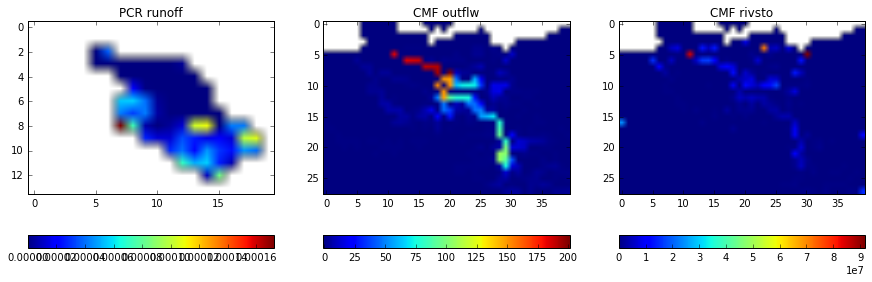

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

# PCR_bmi.update()
# routingModel.update_states()
# routingModel.update() 

runoff = PCR_bmi.get_var('landSurfaceRunoff')
outflw = CMF_bmi.get_var('outflw')
outflw = np.ma.masked_greater(outflw, 1.e19)
rivsto = CMF_bmi.get_var('rivsto_out')
rivsto = np.ma.masked_greater(rivsto, 1.e19)

fig = plt.figure(figsize=(15, 5))
a=fig.add_subplot(1,3,1)
imgplot = plt.imshow(runoff)
a.set_title('PCR runoff')
plt.colorbar(orientation ='horizontal')
a=fig.add_subplot(1,3,2)
imgplot = plt.imshow(outflw)
a.set_title('CMF outflw')
plt.colorbar(orientation='horizontal')
a=fig.add_subplot(1,3,3)
imgplot = plt.imshow(rivsto)
a.set_title('CMF rivsto')
plt.colorbar(orientation='horizontal')

In [16]:
# finalize model
PCR_bmi.finalize()

# finalize model
CMF_bmi.finalize()

INFO: wrapper.finalize(): cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim
2018-03-16 12:37:23,867 bmi.wrapper INFO cd /home/jannis/PhD/code/GLOFRIMplusCAMA/glofrim


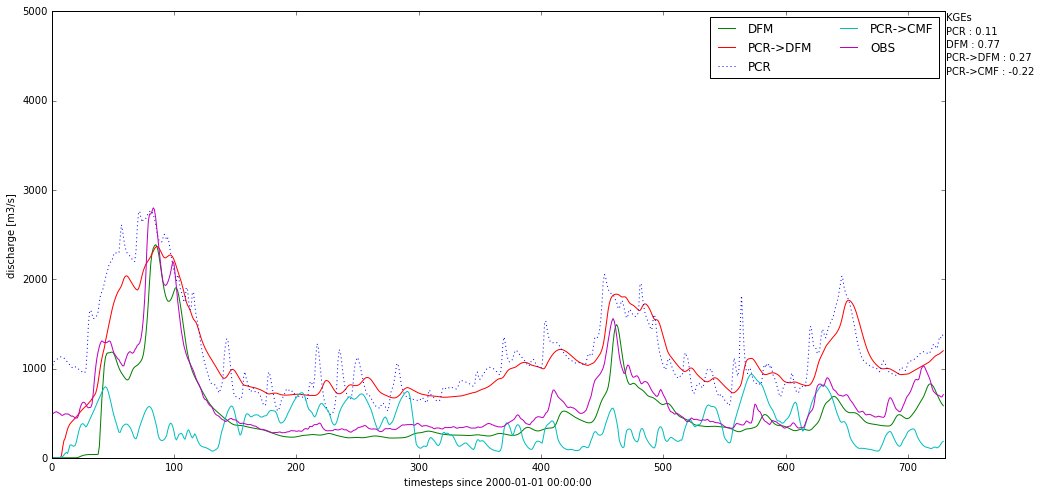

In [24]:
import matplotlib.dates as mdates
from netCDF4 import Dataset

#- laod DFM output file (from 1way coupled PCR->DFM run)
fo_1way = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_1way_his.nc')
#- laod DFM output file (from DFM stand alone)
fo_stA = os.path.join(cwd, 'test_Elbe/', 'DFM_Elbe_VU_standAlone_his.nc')
#- load BfG file
vo = os.path.join(cwd, 'test_Elbe/', 'Elbe-W+Q.csv')
#- load PCR file
po = os.path.join(cwd, 'test_Elbe/', 'Qsim_Elbe_Darchau_30min_2000s_industrial_prefactored.dump')

#- extract BfG data for NeuDarchau
vd = np.loadtxt(vo, unpack=True, converters = {0: mdates.strpdate2num('%d-%m-%y')}, delimiter=';', skiprows=4)
qobs_ND = vd[1]

#- estract PCR data
pd = np.loadtxt(po, unpack=True, skiprows=4)
PCR_ND = pd[1]
PCR_ND = PCR_ND[:]

#- extrat CMF data
cd = np.loadtxt(cmf_outFile, unpack=True)

#- extract simulated discharge from nc-file for 1way PCR->DFM
no_1way = Dataset(fo_1way, 'r')
qsim_1way = no_1way.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_1way = np.absolute(qsim_1way[:,2])
qsim_ND_1way = np.absolute(qsim_1way[:,0])
qsim_downBC_1way = np.absolute(qsim_1way[:,1])

#- extract simulated discharge from nc-file for DFM standalone
no_stA = Dataset(fo_stA, 'r')
qsim_stA = no_stA.variables['cross_section_discharge'][:]
#- split up to different cross-sectiosn
qsim_upBC_stA = np.absolute(qsim_stA[:,2])
qsim_ND_stA = np.absolute(qsim_stA[:,0])
qsim_downBC_stA = np.absolute(qsim_stA[:,1])

#- limit to list with least entries
minLength = min(len(qsim_ND_1way), len(qsim_ND_stA), len(PCR_ND), len(cd))
if len(qobs_ND) > len(cd):
    qobs_ND = qobs_ND[:minLength]
    PCR_ND = PCR_ND[:minLength]
    qsim_ND_1way = qsim_ND_1way[:minLength]
    qsim_ND_stA = qsim_ND_stA[:minLength]
    cd = cd[:minLength]

#- computed KGE at NeuDarchau
KGE_ND_1way = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_1way)
KGE_ND_1way = np.round(KGE_ND_1way,2)
KGE_ND_stA = spotpy.objectivefunctions.kge(qobs_ND, qsim_ND_stA)
KGE_ND_stA = np.round(KGE_ND_stA,2)
KGE_ND_PCR = spotpy.objectivefunctions.kge(qobs_ND, PCR_ND)
KGE_ND_PCR = np.round(KGE_ND_PCR,2)
KGE_ND_CMF = spotpy.objectivefunctions.kge(qobs_ND, cd)
KGE_ND_CMF = np.round(KGE_ND_CMF,2)

#- plot
plt.figure(figsize=(16,8))
# plt.plot(qsim_downBC, ':', c='r', label = 'Qsim downBC')
plt.plot(qsim_ND_stA, 'g', label = 'DFM')
plt.plot(qsim_ND_1way, 'r', label = 'PCR->DFM')
# plt.plot(qsim_downBC, ':',  c='k', label = 'Qsim downBC')
plt.plot(PCR_ND, ':',label = 'PCR')
plt.plot(cd, c='c', label = 'PCR->CMF')
plt.plot(qobs_ND, 'm', label = 'OBS')
plt.text(minLength+1,4900, 'KGEs') 
plt.text(minLength+1,4750, 'PCR : '+str(KGE_ND_PCR))
plt.text(minLength+1,4600, 'DFM : '+str(KGE_ND_stA))
plt.text(minLength+1,4450, 'PCR->DFM : '+str(KGE_ND_1way))
plt.text(minLength+1,4300, 'PCR->CMF : '+str(KGE_ND_CMF))
plt.legend(ncol=2, loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))
plt.savefig(os.path.join(cwd, 'compareAndvalidate_Qsim_PCR2CMF.png'), dpi=300)

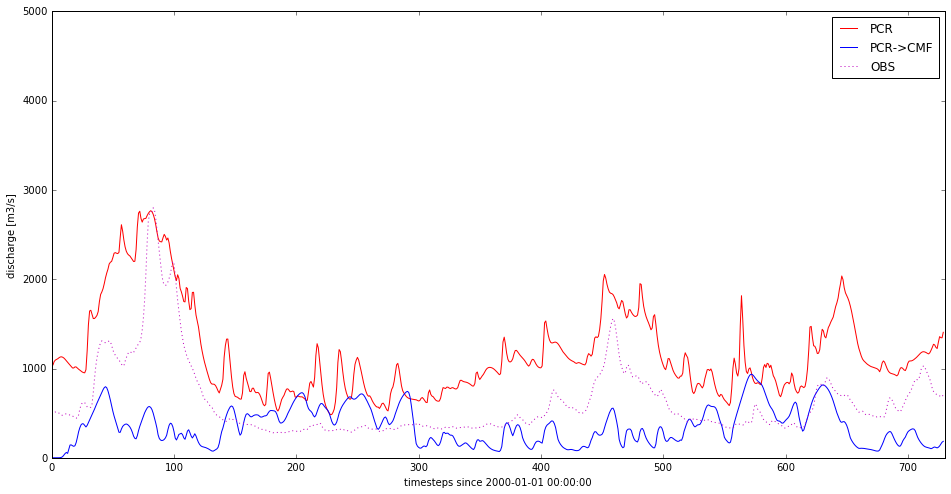

In [22]:
plt.figure(figsize=(16,8))
plt.plot(PCR_ND, 'r',label = 'PCR')
plt.plot(cd, 'b', label = 'PCR->CMF')
plt.plot(qobs_ND, ':', c='m', label = 'OBS')
plt.legend(loc=1)
plt.xlim(0, minLength)
plt.ylim(0, 5000)
plt.ylabel('discharge [m3/s]')
plt.xlabel('timesteps since '+str(start_date))